In [10]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
import joblib

# Load cleaned dataset and keep relevant columns
df = pd.read_csv("../data/data_science_job_posts_2025_clean2.csv")
df = df[[
    "company",
    "skills_clean",
    "skill_count",
    "company_size_group",
    "salary_max",
    "seniority_level",
    "job_title",
]].copy()


In [11]:
# Text columns
df["skills_clean"] = df["skills_clean"].fillna("")
df["job_title"] = df["job_title"].fillna("")

# Categorical columns
df["company_size_group"] = df["company_size_group"].fillna("unknown")
df["seniority_level"] = df["seniority_level"].fillna("unknown")

# Numeric columns: drop rows missing salary or skill_count
df = df.dropna(subset=["salary_max", "skill_count"]).copy()

print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (925, 7)


In [12]:
# One-hot encoding for company_size_group and seniority_level
ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
X_ohe = ohe.fit_transform(df[["company_size_group", "seniority_level"]])
print("One-hot matrix shape:", X_ohe.shape)

# Scaled numeric features: salary_max and skill_count
scaler = StandardScaler()
X_numeric_array = scaler.fit_transform(df[["salary_max", "skill_count"]])
X_numeric = csr_matrix(X_numeric_array)
print("Numeric matrix shape:", X_numeric.shape)


One-hot matrix shape: (925, 8)
Numeric matrix shape: (925, 2)


In [13]:
# ----- TF-IDF for skills_clean -----
tfidf_skills = TfidfVectorizer(token_pattern=r"[^|]+")
X_skills = tfidf_skills.fit_transform(df["skills_clean"])

# ----- TF-IDF for job_title -----
tfidf_titles = TfidfVectorizer(stop_words="english")
X_titles = tfidf_titles.fit_transform(df["job_title"])

# ----- One-hot encode categorical features -----
ohe = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
X_ohe = ohe.fit_transform(df[["company_size_group", "seniority_level"]])

# ----- Scale numeric features -----
scaler = StandardScaler()
X_numeric_array = scaler.fit_transform(df[["salary_max", "skill_count"]])
X_numeric = csr_matrix(X_numeric_array)

# ----- Build final hybrid feature matrix -----
X_hybrid = hstack([
    X_skills,
    X_titles,
    X_ohe,
    X_numeric
]).tocsr()

print("Final hybrid shape:", X_hybrid.shape)


Final hybrid shape: (925, 49)


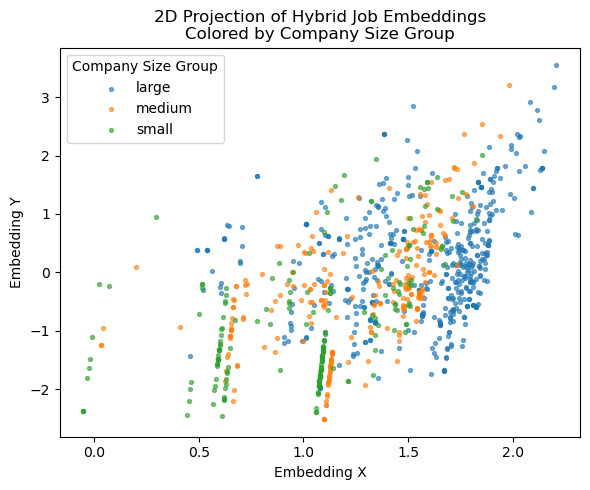

In [14]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_hybrid)

df["emb_x"] = X_2d[:, 0]
df["emb_y"] = X_2d[:, 1]

plt.figure(figsize=(6, 5))

for group in df["company_size_group"].unique():
    subset = df[df["company_size_group"] == group]
    plt.scatter(
        subset["emb_x"],
        subset["emb_y"],
        s=8,
        alpha=0.6,
        label=str(group),
    )

plt.title("2D Projection of Hybrid Job Embeddings\nColored by Company Size Group")
plt.xlabel("Embedding X")
plt.ylabel("Embedding Y")
plt.legend(title="Company Size Group")
plt.tight_layout()
plt.show()


In [15]:
joblib.dump((df, X_hybrid), "../data/hybrid_embeddings.pkl")


['../data/hybrid_embeddings.pkl']